<a href="https://colab.research.google.com/github/aznedac2/CS231N_17_KOR_SUB/blob/master/vol_coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance arch statsmodels seaborn

In [4]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

def fetch_deribit_candles(instrument_name='BTC-PERPETUAL', resolution='1', start_timestamp=None, end_timestamp=None):
    """
    Deribit API에서 캔들 데이터 가져오기
    resolution: '1' for 1-minute, '5' for 5-minute, etc.
    """
    url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"

    params = {
        "instrument_name": instrument_name,
        "resolution": resolution,
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
    }

    resp = requests.get(url, params=params)
    data = resp.json()

    if 'result' not in data:
        print("Error:", data)
        return None

    df = pd.DataFrame(data['result'])
    df['timestamp'] = pd.to_datetime(df['ticks'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']]
    return df

def get_daily_ohlc(start_date, end_date):
    """
    지정된 기간 동안 일별 OHLC 데이터 리턴
    """
    all_data = []
    current_date = start_date
    while current_date <= end_date:
        start_ts = int(current_date.timestamp() * 1000)
        end_ts = int((current_date + timedelta(days=1)).timestamp() * 1000)

        print(f"Fetching data for: {current_date.date()}")
        df = fetch_deribit_candles(start_timestamp=start_ts, end_timestamp=end_ts)

        if df is not None and not df.empty:
            # 일별 OHLC로 리샘플링
            daily = df.resample('1D').agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            })
            all_data.append(daily)

        time.sleep(0.3)  # API 요청 제한 회피
        current_date += timedelta(days=1)

    final_df = pd.concat(all_data)
    return final_df

In [15]:
# 사용 예시
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 4, 5)
df_daily = get_daily_ohlc(start_date, end_date)
print(df_daily)

Fetching data for: 2025-01-01
Fetching data for: 2025-01-02
Fetching data for: 2025-01-03
Fetching data for: 2025-01-04
Fetching data for: 2025-01-05
Fetching data for: 2025-01-06
Fetching data for: 2025-01-07
Fetching data for: 2025-01-08
Fetching data for: 2025-01-09
Fetching data for: 2025-01-10
Fetching data for: 2025-01-11
Fetching data for: 2025-01-12
Fetching data for: 2025-01-13
Fetching data for: 2025-01-14
Fetching data for: 2025-01-15
Fetching data for: 2025-01-16
Fetching data for: 2025-01-17
Fetching data for: 2025-01-18
Fetching data for: 2025-01-19
Fetching data for: 2025-01-20
Fetching data for: 2025-01-21
Fetching data for: 2025-01-22
Fetching data for: 2025-01-23
Fetching data for: 2025-01-24
Fetching data for: 2025-01-25
Fetching data for: 2025-01-26
Fetching data for: 2025-01-27
Fetching data for: 2025-01-28
Fetching data for: 2025-01-29
Fetching data for: 2025-01-30
Fetching data for: 2025-01-31
Fetching data for: 2025-02-01
Fetching data for: 2025-02-02
Fetching d

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import skew, kurtosis, normaltest

# 1. 데이터 수집 (BTCUSDT)
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-04-01")
btc.columns = btc.columns.levels[0]
btc["log_ret"] = np.log(btc["Close"] / btc["Close"].shift(1))
returns = btc["log_ret"].dropna()


[*********************100%***********************]  1 of 1 completed


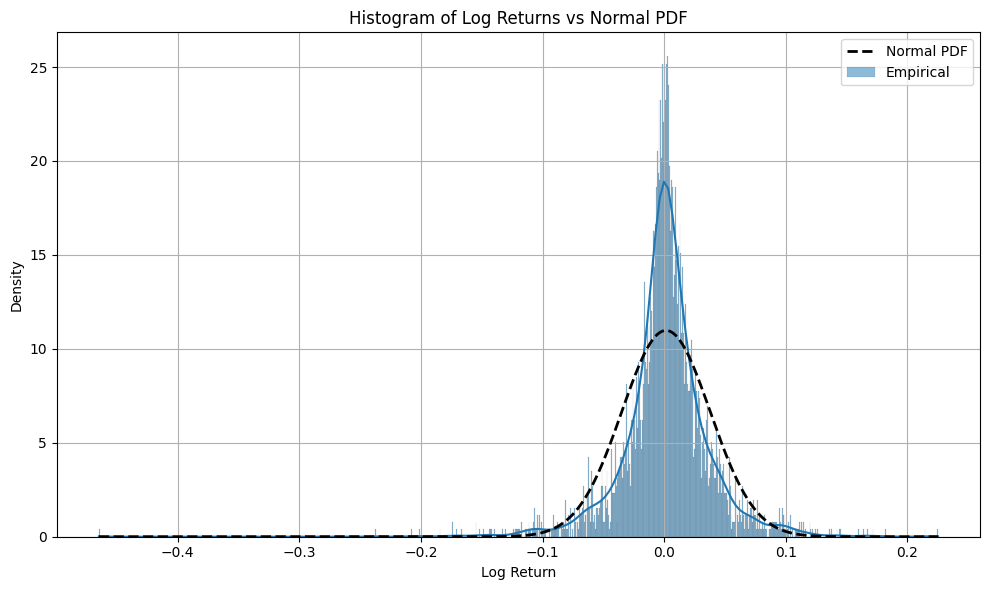

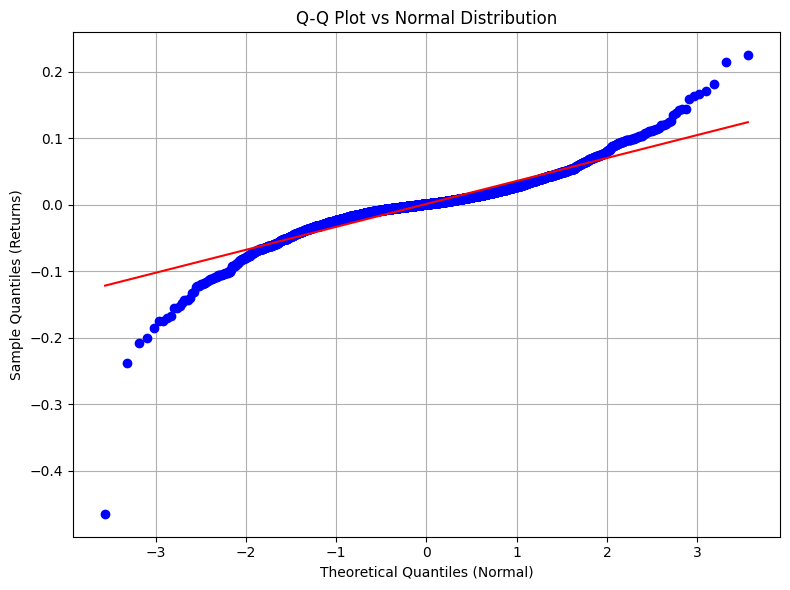

Normality Test p-value: 0.0000
p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import norm

# 히스토그램 + 정규분포 PDF 비교 시각화
plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=1000, kde=True, stat="density", label="Empirical")

# 정규분포 PDF 계산
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, color='black', linestyle='--', linewidth=2, label="Normal PDF")

# 그래프 설정
# plt.xlim(-0.2, -0.1)
plt.title("Histogram of Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q 플롯 (정규분포와 비교)
plt.figure(figsize=(8, 6))
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot vs Normal Distribution")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles (Returns)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 분포 분석
stat, p = normaltest(returns)
print(f"Normality Test p-value: {p:.4f}")
print('p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움')


In [31]:
print(f"Skewness: {skew(returns):.3f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.3f}")

print('Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음')

Skewness: -0.744
Kurtosis: 11.557
Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음


In [27]:
# 3. ARCH 효과 테스트
arch_stat, arch_pvalue, _, _ = het_arch(returns)
print(f"ARCH test p-value: {arch_pvalue:.4f}")

# 4. GARCH(1,1) 적합
model = arch_model(returns, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())


ARCH test p-value: 0.0000
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2582.65
Distribution:                  Normal   AIC:                          -5157.30
Method:            Maximum Likelihood   BIC:                          -5136.99
                                        No. Observations:                 1185
Date:                Mon, Apr 21 2025   Df Residuals:                     1184
Time:                        04:22:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1810e-03  7.340e

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


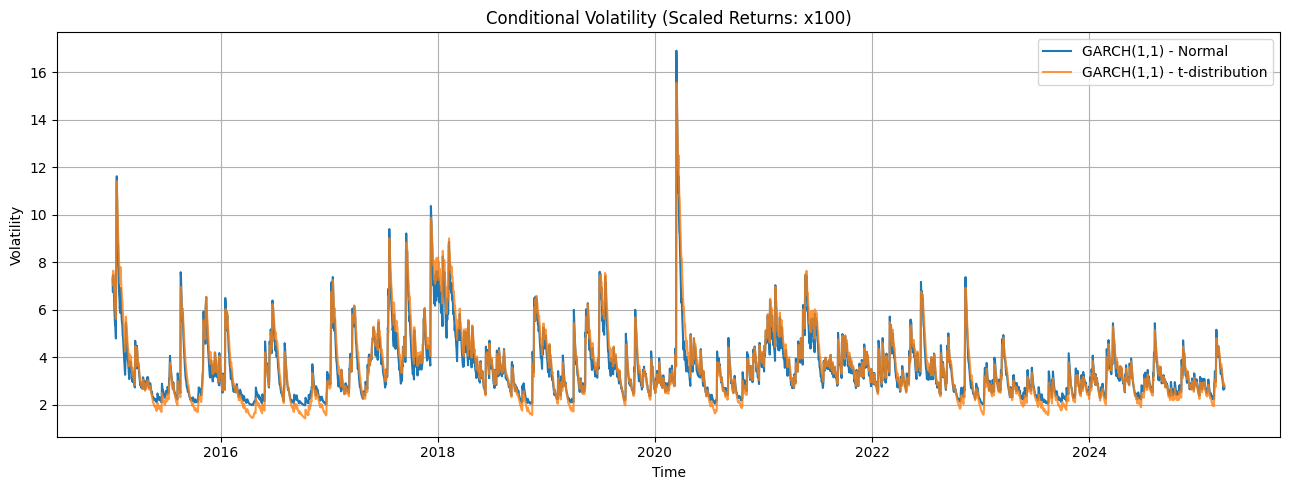

AIC (Normal): 19610.99
AIC (t-dist): 18645.75
Estimated nu (t-dist degrees of freedom): 3.16


In [48]:
# 📌 GARCH 최적화 안정성을 위해 스케일 조정
returns_scaled = returns * 100

# GARCH(1,1) - Normal
model_normal = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='normal')
res_normal = model_normal.fit(disp='off')

# GARCH(1,1) - t-distribution
model_t = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='t')
res_t = model_t.fit(disp='off')

# 조건부 변동성
vol_normal = res_normal.conditional_volatility
vol_t = res_t.conditional_volatility

# 시각화
plt.figure(figsize=(13, 5))
plt.plot(vol_normal, label='GARCH(1,1) - Normal')
plt.plot(vol_t, label='GARCH(1,1) - t-distribution', alpha=0.8)
plt.title("Conditional Volatility (Scaled Returns: x100)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 성능 지표 출력
print(f"AIC (Normal): {res_normal.aic:.2f}")
print(f"AIC (t-dist): {res_t.aic:.2f}")
print(f"Estimated nu (t-dist degrees of freedom): {res_t.params['nu']:.2f}")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skewness: 0.0867
Kurtosis: 22.2356
Normality test p-value: 0.0000


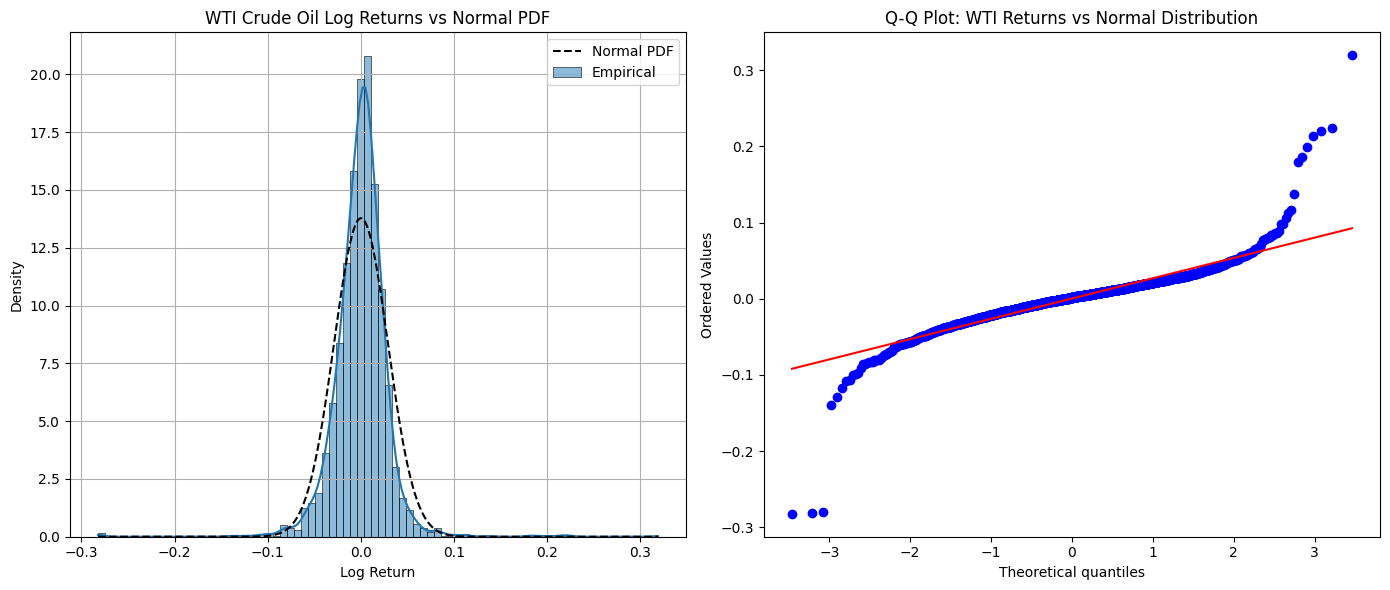

In [41]:
# 1. WTI 원유 선물 데이터 다운로드 (CL=F)
wti = yf.download("CL=F", start="2015-01-01", end="2025-04-01")
wti.columns = wti.columns.levels[0]
wti["log_ret"] = np.log(wti["Close"] / wti["Close"].shift(1))
returns = wti["log_ret"].dropna()

# 2. 통계량 계산
print(f"Skewness: {skew(returns):.4f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.4f}")
print(f"Normality test p-value: {normaltest(returns).pvalue:.4f}")

# 3. 시각화: 히스토그램 + 정규분포 PDF
plt.figure(figsize=(14, 6))

# 히스토그램 + 정규 PDF
plt.subplot(1, 2, 1)
sns.histplot(returns, bins=80, kde=True, stat="density", label="Empirical")
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, 'k--', label='Normal PDF')
plt.title("WTI Crude Oil Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Q-Q 플롯
plt.subplot(1, 2, 2)
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot: WTI Returns vs Normal Distribution")

plt.tight_layout()
plt.show()


In [166]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime

# Black-Scholes 가격 계산 함수
def bs_price(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied Volatility 계산 함수
def implied_vol(price, option_type, S, K, T, r):
    try:
        # return brentq(lambda sigma: bs_price(option_type, S, K, T, r, sigma) - price, 1e-5, 1)
        return brentq(lambda sigma: bs_price(option_type, S, K, T, r, sigma) - price * S, 1e-5, 1)
    except:
        return np.nan

# Deribit에서 옵션 리스트 가져오기
def get_option_instruments(currency="BTC", kind="option", expired=False):
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {
        "currency": currency,
        "kind": kind,
        "expired": str(expired).lower()  # API는 'true' or 'false' string을 요구함
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'error' in data:
        print(f"API Error: {data['error']['message']}")
        return []

    instruments = data.get("result", [])
    return instruments

# 옵션별 IV 계산
def get_iv_for_option(inst_name, strike, expiry_timestamp, mode='mid', r=0):
    url = f"https://www.deribit.com/api/v2/public/get_order_book?instrument_name={inst_name}"
    response = requests.get(url)
    if response.status_code != 200 or 'result' not in response.json():
      return None
    data = response.json().get('result', {})

    S = data.get('underlying_price')
    if abs(strike - S) / S > 0.5:
      return None
    K = strike
    bid = data.get('best_bid_price')
    ask = data.get('best_ask_price')
    mid = (bid + ask) / 2 if bid and ask else None

    mark_iv = data.get('mark_iv')
    bid_iv = data.get('bid_iv')
    ask_iv = data.get('ask_iv')

    # S2 = get_btc_futures_last_price()

    if mode == 'mid':
      mid = mid
    elif mode == 'bid':
      mid = bid
    elif mode == 'ask':
      mid = ask

    if not mid:
        return None

    if not expiry_timestamp:
        return None
    T = (datetime.utcfromtimestamp(expiry_timestamp / 1000) - datetime.utcnow()).total_seconds() / (365 * 24 * 60 * 60)

    if T <= 0:
        return None

    opt_type = inst_name[-1]
    if opt_type == 'C':
        opt_type = 'call'
    elif opt_type == 'P':
        opt_type = 'put'
    else:
        return None

    iv = implied_vol(mid, opt_type, S, K, T, r)

    expiry_date = datetime.utcfromtimestamp(expiry_timestamp / 1000).strftime('%Y-%m-%d')
    return {
        'strike': K,
        'iv': iv,
        'expiry': expiry_date,
        'mark_iv': mark_iv,
        'bid_iv': bid_iv,
        'ask_iv': ask_iv
    }

# 만기별 Smile Curve 시각화
def plot_smile_curves(cp, mode, cutoff_str):
    options = get_option_instruments()
    iv_data = []

    cutoff_date = datetime.strptime(cutoff_str, '%Y%m%d')
    cutoff_timestamp = int(cutoff_date.timestamp() * 1000)

    for opt in options:
        inst_name = opt['instrument_name']
        opt_type = inst_name[-1]
        strike_opt =  opt['strike']

        expiry_timestamp_opt = opt['expiration_timestamp']
        if (cp != opt_type) or (expiry_timestamp_opt > cutoff_timestamp):
          continue

        iv_info = get_iv_for_option(inst_name, strike_opt, expiry_timestamp_opt, mode)

        if iv_info and iv_info['iv'] is not None and iv_info['iv'] is not np.nan:
            print(inst_name, iv_info)
            iv_data.append(iv_info)

    df = pd.DataFrame(iv_data)
    df = df.dropna().sort_values(['expiry', 'strike'])

    plt.figure(figsize=(12, 6))
    for expiry in sorted(df['expiry'].unique()):
        subset = df[df['expiry'] == expiry]
        plt.plot(subset['strike'], subset['iv'], marker='o', label=expiry)

    plt.title("BTC " + cp + " Implied Volatility Smile Curves by Expiry by " + mode)
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend(title="Expiry")
    plt.tight_layout()
    plt.show()

    df['cp'] = cp
    df['mode'] = mode
    return df

def get_btc_futures_last_price(instrument_name="BTC-PERPETUAL"):
    """
    Deribit에서 지정한 비트코인 선물 종목의 현재가(last price)를 반환합니다.

    Parameters:
    - instrument_name: 예) 'BTC-PERPETUAL', 'BTC-27JUN25'

    Returns:
    - 현재가 (float), 실패 시 None
    """
    url = "https://www.deribit.com/api/v2/public/ticker"
    params = {"instrument_name": instrument_name}

    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data["result"]["last_price"]
    except Exception as e:
        print(f"에러 발생: {e}")
        return None

BTC-22APR25-85000-C {'strike': 85000.0, 'iv': 0.38003772771823735, 'expiry': '2025-04-22', 'mark_iv': 47.88, 'bid_iv': 0.0, 'ask_iv': 58.97}
BTC-22APR25-86000-C {'strike': 86000.0, 'iv': 0.43592080337491795, 'expiry': '2025-04-22', 'mark_iv': 46.81, 'bid_iv': 27.75, 'ask_iv': 55.78}
BTC-22APR25-86500-C {'strike': 86500.0, 'iv': 0.39152923458969385, 'expiry': '2025-04-22', 'mark_iv': 46.09, 'bid_iv': 34.21, 'ask_iv': 43.85}
BTC-22APR25-87000-C {'strike': 87000.0, 'iv': 0.42375974490545626, 'expiry': '2025-04-22', 'mark_iv': 45.35, 'bid_iv': 39.6, 'ask_iv': 45.12}
BTC-22APR25-87500-C {'strike': 87500.0, 'iv': 0.443872231903345, 'expiry': '2025-04-22', 'mark_iv': 45.54, 'bid_iv': 43.05, 'ask_iv': 45.7}
BTC-22APR25-88000-C {'strike': 88000.0, 'iv': 0.4429253717588359, 'expiry': '2025-04-22', 'mark_iv': 44.67, 'bid_iv': 42.91, 'ask_iv': 45.66}
BTC-22APR25-88500-C {'strike': 88500.0, 'iv': 0.44141388981075425, 'expiry': '2025-04-22', 'mark_iv': 44.55, 'bid_iv': 42.91, 'ask_iv': 45.38}
BTC-22

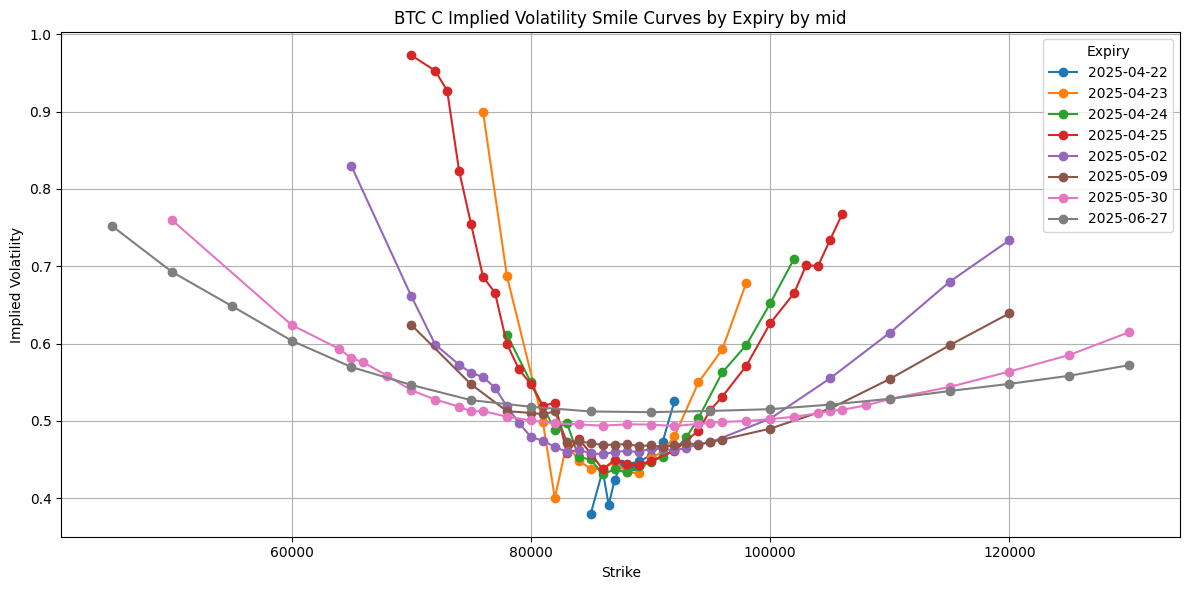

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,cp,mode
0,85000.0,0.380038,2025-04-22,47.88,0.00,58.97,C,mid
1,86000.0,0.435921,2025-04-22,46.81,27.75,55.78,C,mid
2,86500.0,0.391529,2025-04-22,46.09,34.21,43.85,C,mid
3,87000.0,0.423760,2025-04-22,45.35,39.60,45.12,C,mid
4,87500.0,0.443872,2025-04-22,45.54,43.05,45.70,C,mid
...,...,...,...,...,...,...,...,...
180,110000.0,0.528684,2025-06-27,52.93,52.66,53.08,C,mid
181,115000.0,0.538775,2025-06-27,53.86,53.38,54.37,C,mid
182,120000.0,0.548002,2025-06-27,54.89,54.50,55.10,C,mid
183,125000.0,0.558479,2025-06-27,56.08,55.49,56.20,C,mid


In [167]:
# 실행
df_mid = plot_smile_curves(cp='C', mode='mid', cutoff_str='20250630')
df_mid

BTC-22APR25-82000-C {'strike': 82000.0, 'iv': 0.8645915235413781, 'expiry': '2025-04-22', 'mark_iv': 63.3, 'bid_iv': 0.0, 'ask_iv': 86.46}
BTC-22APR25-83000-C {'strike': 83000.0, 'iv': 0.8647400498123856, 'expiry': '2025-04-22', 'mark_iv': 55.59, 'bid_iv': 0.0, 'ask_iv': 86.48}
BTC-22APR25-84000-C {'strike': 84000.0, 'iv': 0.64997621636398, 'expiry': '2025-04-22', 'mark_iv': 51.06, 'bid_iv': 0.0, 'ask_iv': 65.0}
BTC-22APR25-85000-C {'strike': 85000.0, 'iv': 0.5483441408310995, 'expiry': '2025-04-22', 'mark_iv': 48.02, 'bid_iv': 0.0, 'ask_iv': 54.84}
BTC-22APR25-86000-C {'strike': 86000.0, 'iv': 0.5242737205386958, 'expiry': '2025-04-22', 'mark_iv': 46.91, 'bid_iv': 21.95, 'ask_iv': 52.43}
BTC-22APR25-86500-C {'strike': 86500.0, 'iv': 0.43597253129861213, 'expiry': '2025-04-22', 'mark_iv': 46.04, 'bid_iv': 37.38, 'ask_iv': 43.6}
BTC-22APR25-87000-C {'strike': 87000.0, 'iv': 0.4451503885112469, 'expiry': '2025-04-22', 'mark_iv': 45.07, 'bid_iv': 41.78, 'ask_iv': 44.52}
BTC-22APR25-87500-

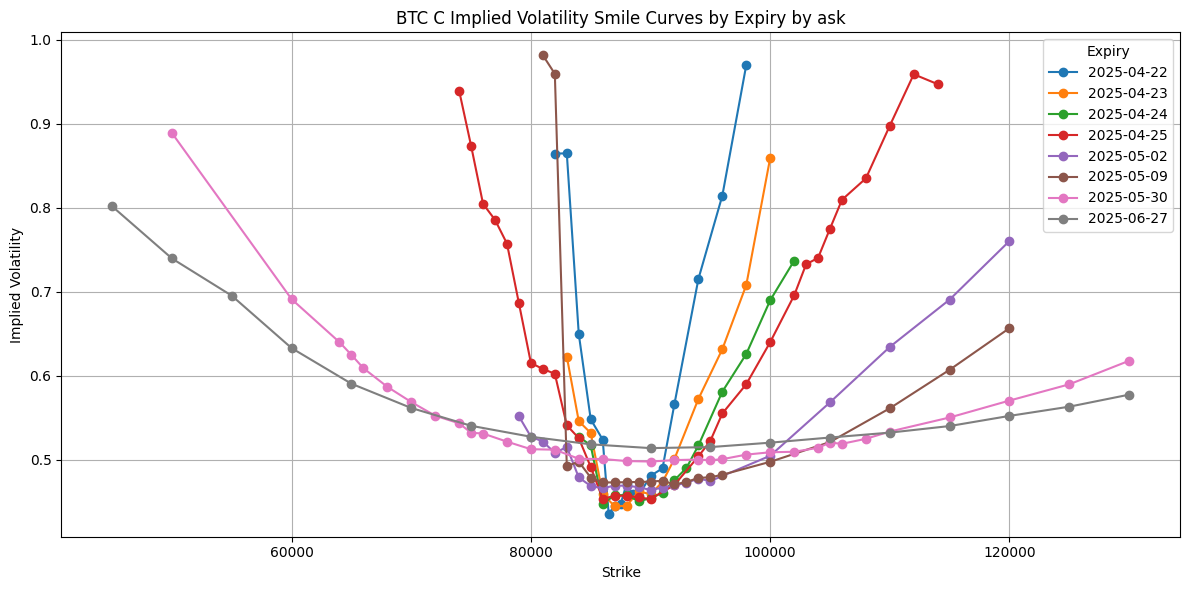

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,cp,mode
0,82000.0,0.864592,2025-04-22,63.30,0.00,86.46,C,ask
1,83000.0,0.864740,2025-04-22,55.59,0.00,86.48,C,ask
2,84000.0,0.649976,2025-04-22,51.06,0.00,65.00,C,ask
3,85000.0,0.548344,2025-04-22,48.02,0.00,54.84,C,ask
4,86000.0,0.524274,2025-04-22,46.91,21.95,52.43,C,ask
...,...,...,...,...,...,...,...,...
168,110000.0,0.532545,2025-06-27,52.94,52.83,53.25,C,ask
169,115000.0,0.540381,2025-06-27,53.87,53.54,54.04,C,ask
170,120000.0,0.552454,2025-06-27,54.90,54.65,55.25,C,ask
171,125000.0,0.563418,2025-06-27,56.09,55.63,56.34,C,ask


In [168]:
# 실행
df_ask = plot_smile_curves(cp='C', mode='ask', cutoff_str='20250630')
df_ask

BTC-22APR25-86000-C {'strike': 86000.0, 'iv': 0.2743286952254864, 'expiry': '2025-04-22', 'mark_iv': 46.9, 'bid_iv': 27.43, 'ask_iv': 57.1}
BTC-22APR25-86500-C {'strike': 86500.0, 'iv': 0.3561117886166176, 'expiry': '2025-04-22', 'mark_iv': 45.81, 'bid_iv': 35.61, 'ask_iv': 44.7}
BTC-22APR25-87000-C {'strike': 87000.0, 'iv': 0.39558092051388144, 'expiry': '2025-04-22', 'mark_iv': 44.94, 'bid_iv': 39.55, 'ask_iv': 44.97}
BTC-22APR25-87500-C {'strike': 87500.0, 'iv': 0.41988193197332624, 'expiry': '2025-04-22', 'mark_iv': 45.37, 'bid_iv': 41.98, 'ask_iv': 44.64}
BTC-22APR25-88000-C {'strike': 88000.0, 'iv': 0.42549078771798193, 'expiry': '2025-04-22', 'mark_iv': 44.72, 'bid_iv': 42.54, 'ask_iv': 46.49}
BTC-22APR25-88500-C {'strike': 88500.0, 'iv': 0.41958471616487236, 'expiry': '2025-04-22', 'mark_iv': 44.47, 'bid_iv': 41.95, 'ask_iv': 45.2}
BTC-22APR25-89000-C {'strike': 89000.0, 'iv': 0.42625354868732585, 'expiry': '2025-04-22', 'mark_iv': 44.68, 'bid_iv': 41.8, 'ask_iv': 46.55}
BTC-22

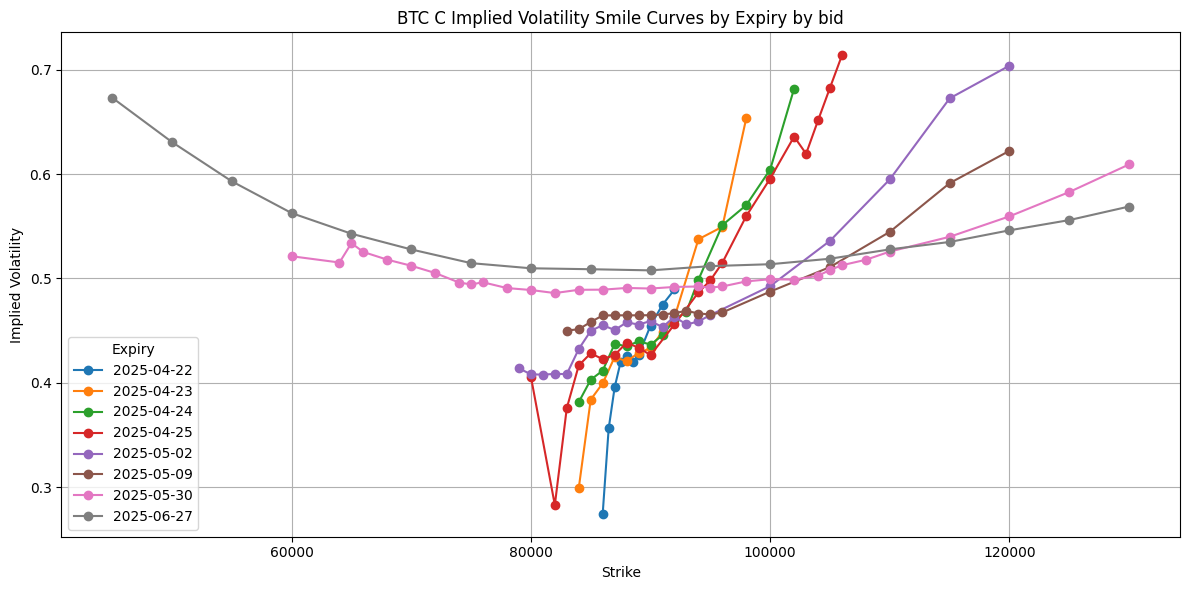

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,cp,mode
0,86000.0,0.274329,2025-04-22,46.90,27.43,57.10,C,bid
1,86500.0,0.356112,2025-04-22,45.81,35.61,44.70,C,bid
2,87000.0,0.395581,2025-04-22,44.94,39.55,44.97,C,bid
3,87500.0,0.419882,2025-04-22,45.37,41.98,44.64,C,bid
4,88000.0,0.425491,2025-04-22,44.72,42.54,46.49,C,bid
...,...,...,...,...,...,...,...,...
145,110000.0,0.527807,2025-06-27,52.94,52.78,53.20,C,bid
146,115000.0,0.534911,2025-06-27,53.88,53.49,53.99,C,bid
147,120000.0,0.546076,2025-06-27,54.91,54.61,55.20,C,bid
148,125000.0,0.555887,2025-06-27,56.11,55.59,56.30,C,bid


In [169]:
# 실행
df_bid = plot_smile_curves(cp='C', mode='bid', cutoff_str='20250630')
df_bid

In [170]:
df_ask = df_ask[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_ask'})
df_bid = df_bid[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_bid'})

df_merged = pd.merge(df_bid, df_ask, on=["strike", "expiry"], how="inner")[['strike', 'expiry', 'iv_bid', 'iv_ask']]

df_merged

,strike,expiry,iv_bid,iv_ask
0,86000.0,2025-04-22,0.274329,0.524274
1,86500.0,2025-04-22,0.356112,0.435973
2,87000.0,2025-04-22,0.395581,0.445150
3,87500.0,2025-04-22,0.419882,0.447606
4,88000.0,2025-04-22,0.425491,0.471622
...,...,...,...,...
145,110000.0,2025-06-27,0.527807,0.532545
146,115000.0,2025-06-27,0.534911,0.540381
147,120000.0,2025-06-27,0.546076,0.552454
148,125000.0,2025-06-27,0.555887,0.563418


In [171]:
import plotly.express as px

# melt로 long form 변환|
df_long = pd.melt(
    df_merged,
    id_vars=["strike", "expiry"],
    value_vars=["iv_bid", "iv_ask"],
    var_name="iv_type",
    value_name="implied_volatility"
)

# Plotly로 인터랙티브 그래프 그리기
fig = px.line(
    df_long,
    x="strike",
    y="implied_volatility",
    color="expiry",
    line_dash="iv_type",
    markers=True,
    title="Interactive Implied Volatility Curve by Expiry and IV Type",
    labels={"strike": "Strike", "implied_volatility": "Implied Volatility"}
)

fig.update_layout(legend_title_text="Expiry / IV Type", hovermode="x unified")
fig.show()

In [37]:
get_iv_for_option(inst_name)

{'timestamp': 1745227517223, 'state': 'open', 'stats': {'high': None, 'low': None, 'price_change': None, 'volume': 0.0, 'volume_usd': 0.0}, 'greeks': {'delta': 0.99991, 'gamma': 0.0, 'vega': 0.01606, 'theta': -0.5964, 'rho': 1.95908}, 'change_id': 97992839864, 'index_price': 87448.23, 'instrument_name': 'BTC-22APR25-76000-C', 'bids': [[0.0995, 10.3]], 'asks': [[0.1605, 10.3]], 'last_price': None, 'settlement_price': 0.13092624, 'min_price': 0.0995, 'max_price': 0.1605, 'open_interest': 0.0, 'mark_price': 0.131, 'best_ask_price': 0.1605, 'best_bid_price': 0.0995, 'interest_rate': 0.0, 'mark_iv': 74.25, 'bid_iv': 0.0, 'ask_iv': 414.29, 'underlying_price': 87456.8408, 'underlying_index': 'SYN.BTC-22APR25', 'estimated_delivery_price': 87448.23, 'best_ask_amount': 10.3, 'best_bid_amount': 10.3}


In [13]:
get_option_instruments()[0]

{'price_index': 'btc_usd',
 'rfq': False,
 'kind': 'option',
 'instrument_name': 'BTC-22APR25-76000-C',
 'maker_commission': 0.0003,
 'taker_commission': 0.0003,
 'instrument_type': 'reversed',
 'expiration_timestamp': 1745308800000,
 'creation_timestamp': 1745049608000,
 'is_active': True,
 'tick_size': 0.0001,
 'contract_size': 1.0,
 'strike': 76000.0,
 'base_currency': 'BTC',
 'instrument_id': 455660,
 'settlement_period': 'day',
 'min_trade_amount': 0.1,
 'option_type': 'call',
 'block_trade_commission': 0.0003,
 'block_trade_min_trade_amount': 25,
 'block_trade_tick_size': 0.0001,
 'settlement_currency': 'BTC',
 'counter_currency': 'USD',
 'quote_currency': 'BTC',
 'tick_size_steps': [{'tick_size': 0.0005, 'above_price': 0.005}]}